## Studying Growth Instability

This code lets us explore how QLC-2 solutions vary with the following parameters:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In addition, there's the possibility of activating the "microsurface" capablity, by specifying microsurfaces=1. In that case, additional parameters are needed:
- $\sigma_0$ multiplier (how the volatility of the pyramidal facet compares to that of the prismatic (>1 => less volatile)
- $h_{py}$ multiplier (how the thickness of a pyramidal compares to that of the prismatic (>1 => thicker)
- $N^*$ multiplier (how the variability of the pyramidal facet compares to that of the prismatic (>1 => more variable)
- $\theta$ (angle of the additional microfacet with respect to the prismatic (for pyramidal, this is 28 degrees)
- $\beta_{trans}$ multiplier (gradualness of transition between microfacet angles (smaller => more gradual))

In [12]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from matplotlib import rcParams
import matplotlib.animation as animation

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [13]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

### Specifying the input namelist file

In [14]:
# inputfile = "GI parameters - Reference limit cycle.nml"
# inputfile = "GI parameters - Reference limit cycle with microfacets.nml"
# inputfile = "GI parameters - Reference limit cycle with no-growth microfacets.nml"
# inputfile = "GI parameters - Microsurface=0, but no-growth pyramidal-like parameters.nml"
inputfile = "GI parameters - 5 degree, no-growth microfaceting.nml"
# inputfile = "GI parameters - 10 degree, no-growth microfaceting.nml"
# inputfile = "GI parameters - 5 degree, growth-capable microfaceting.nml"

### Getting parameters for this run

In [15]:
# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Smoothing parameter
d2Ntot_dx2_threshold = GI['d2Ntot_dx2_threshold']
d2Ntot_dx2_threshold_units = GI['d2Ntot_dx2_threshold_units']
d2Ntot_dx2_threshold = AssignQuantity(d2Ntot_dx2_threshold,d2Ntot_dx2_threshold_units)
print('d2Ntot_dx2_threshold =',d2Ntot_dx2_threshold)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

# Microfacet flag
microfacets = GI['microfacets']
print('microfacets =',microfacets)

# Some dependent values of interest
print('=> facet supersaturation (at corners) =',sigmaI_corner-sigma0)
print('=> facet supersaturation (at middle) =',sigmaI_corner*(1-c_r.to('dimensionless'))-sigma0)

if microfacets == 1:
    # For readability ...
    print('\nFrom the microfacet (MF) namelist:')
    MF=f90nml.read(inputfile)['MF'] # Read the microfacet namelist too
    
    # How the volatility of the pyramidal facet compares to that of the prismatic (>1 => less volatile)
    sigma0factor = MF['sigma0factor']
    print('sigma0factor =',sigma0factor)
    
    # How the pyramidal layer thickness compares to the prismatic (>1 => thicker)
    h_pyfactor = MF['h_pyfactor']
    print('h_pyfactor =',h_pyfactor)

    # How the variability of the pyramidal facet compares to that of the prismatic (>1 => more variable)
    Nstarfactor = MF['Nstarfactor']
    print('Nstarfactor =',Nstarfactor)
    
    # Angle of the microfacet
    theta = MF['theta']
    theta_units = MF['theta_units']
    theta = AssignQuantity(theta,theta_units)
    print('theta =',theta)

    # Gradualness of transition between prismatic and pyramidal angles (smaller => more gradual)
    beta_trans_factor = MF['beta_trans_factor']
    print('beta_trans_factor =',beta_trans_factor)
    
    # Some dependent values of interest
    print('=> h_py =',h_pyfactor*h_pr)
    print('=> microfacet Nstar =', Nstar*Nstarfactor)
    print('=> microfacet sigma0 =', sigma0*sigma0factor)
    print('=> microfacet supersaturation (at corners) =',sigmaI_corner-sigma0*sigma0factor)
    print('=> microfacet supersaturation (at middle) =',sigmaI_corner*(1-c_r.to('dimensionless'))-sigma0*sigma0factor)

else: 
    # Have to supply dummy variables, but they won't be used
    sigma0factor = 1
    h_pyfactor = 1
    Nstarfactor = 1
    theta = AssignQuantity(0,'degree')
    beta_trans_factor = 1

Using parameter file GI parameters - 5 degree, no-growth microfaceting.nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 23 percent
sigma0 = 20 percent
c_r = 1 percent
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 140 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
d2Ntot_dx2_threshold = 10000 / micrometer ** 2
odemethod = RK45
microfacets = 1
=> facet supersaturation (at corners) = 3 percent
=> facet supersaturation (at middle) = 2.7699999999999996 percent

From the microfacet (MF) namelist:
sigma0factor = 1.2
h_pyfactor = 1
Nstarfactor = 0.9
theta = 5 degree
beta_trans_factor = 10
=> h_py = 0.389 nanometer
=> microfacet Nstar = 0.09000000000000001
=> microfacet sigma0 = 24.0 percent
=> microfacet supersaturation (at corners) = -1.0 percent
=> microfacet supersaturation (at middle) = -1.2300000000000004 percent


In [16]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

### Varibles that depend on the above

In [17]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Run the scenario

In [18]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# This is code to extend a previous calculation:
# First time through, "extending" has to equal 0
# If set to 1, execute this cell and below
extending = 0
if extending == 0:
    tkeep_1Darr = np.linspace(0,runtime,ntimes)
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)
else:
    runtime = AssignQuantity(2000,'millisecond') # Use this line to override the estimated time
    tlast.ito('microsecond')
    tstart = tkeep_1Darr[-1]
    tstop = tstart + runtime
    tkeep_1Darr = np.linspace(tstart,tstop,ntimes)
    Ntot_init_1D = Ntotkeep_1D[-1,:]
    NQLL_init_1D = NQLLkeep_1D[-1,:]

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r.to('percent').magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
    
# Solve the 1-D problem
Ntotkeep_1D, NQLLkeep_1D = QLC.run_pypr(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, \
                    theta, beta_trans_factor, Nstarfactor, h_pr, h_pyfactor, sigma0factor,\
                    sigmaI_QLC, x_QLC, d2Ntot_dx2_threshold,
                    AssignQuantity,\
                    verbose, odemethod=odemethod, microfacets=microfacets)
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

runtime = 4000 millisecond
This is a run from time 0.0 millisecond to 4000.0 millisecond
dt = 20100.502512562813 microsecond
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
10 % elapsed time is 1.433 minutes
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list

alpha_sticking relative to sigmaI_corner = -4.057549908679173e-11 dimensionless


Text(0, 0.5, 'Thickness ($\\mu m)$')

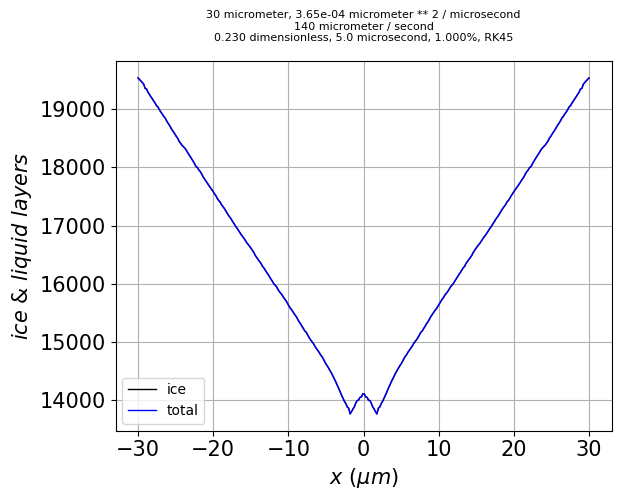

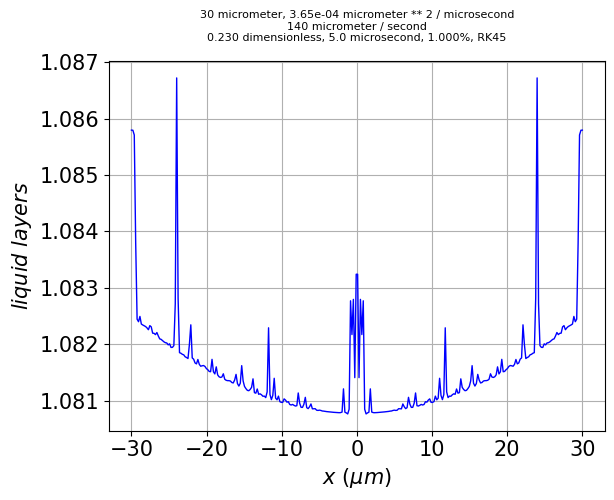

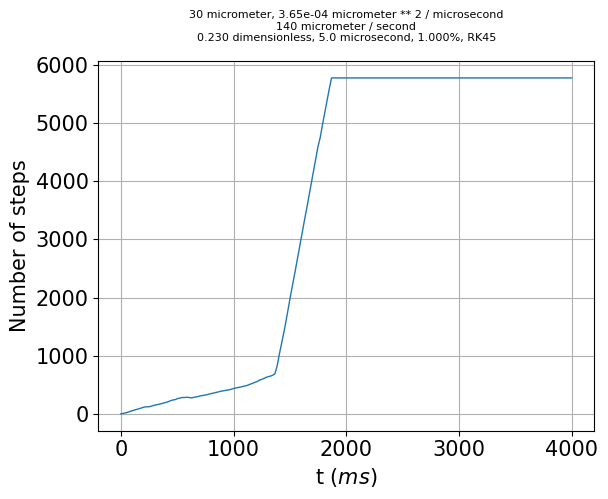

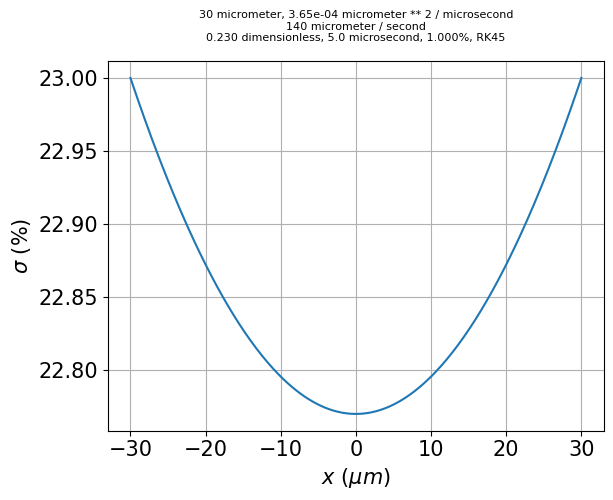

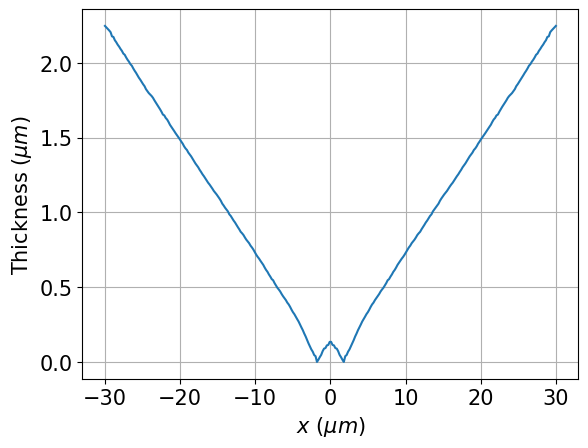

In [19]:
# Reporting and graphing
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

# This is only of interest if we're looking at the "sticking" coefficient
alpha_sticking = g_ice_QLC/(sigmaI_corner*nu_kin)
alpha_sticking = AssignQuantity(alpha_sticking,'dimensionless')
print('alpha_sticking relative to sigmaI_corner =',alpha_sticking)

# Additional graphing
plt.figure()
plt.plot(x_QLC.magnitude,sigmaI_QLC.magnitude*100)
plt.grid(True)
plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.title(title_params,fontsize=titlefontsize)

# Ntot in micrometers (instead of layers)
plt.figure()
ydiff = Ntotkeep_1D[-1,:]*h_pr
ydiff = ydiff - np.min(ydiff)
plt.plot(x_QLC.magnitude,ydiff.magnitude)
plt.grid(True)
plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
plt.ylabel('Thickness ($\mu m)$',fontsize=fontsize)

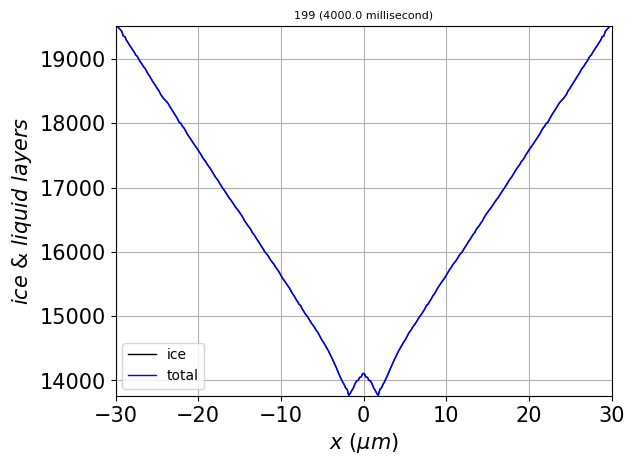

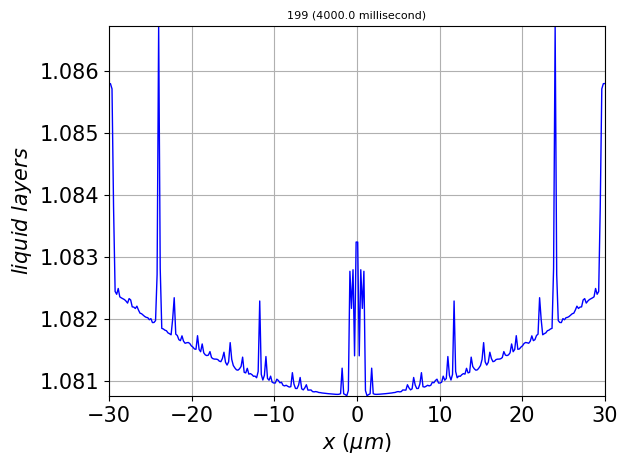

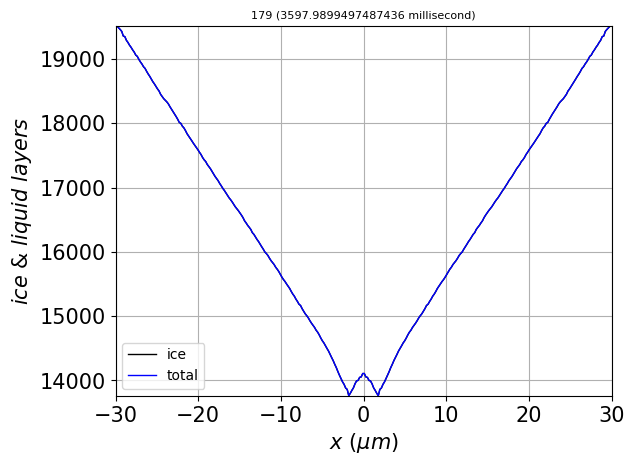

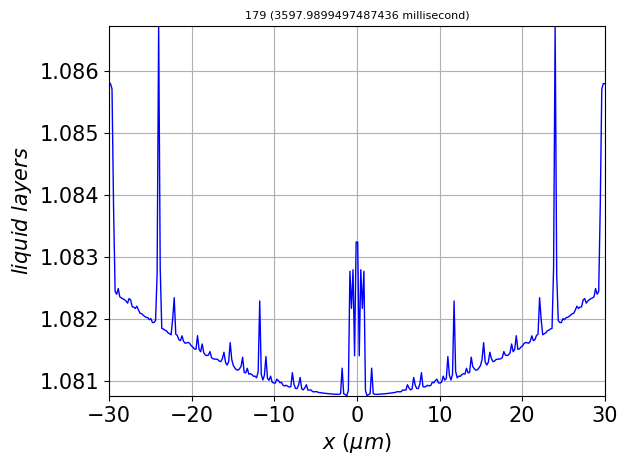

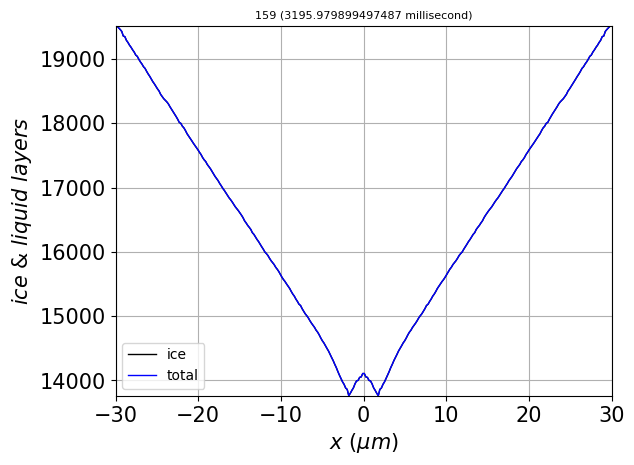

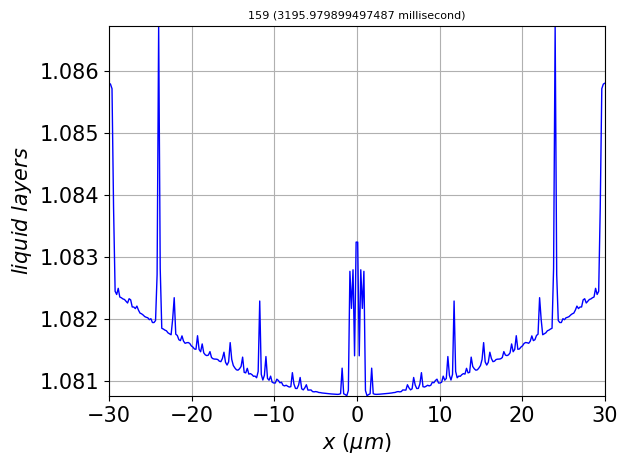

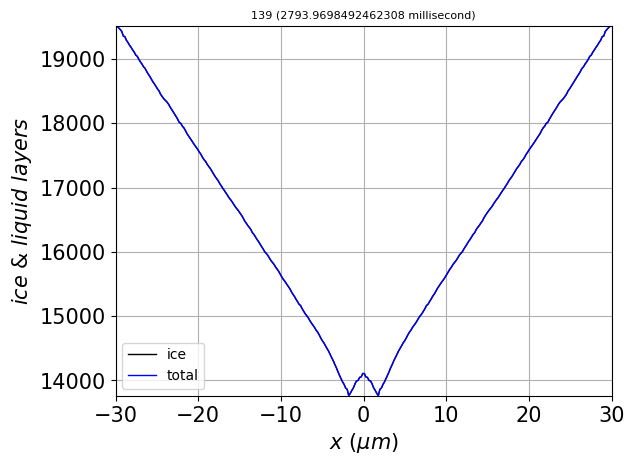

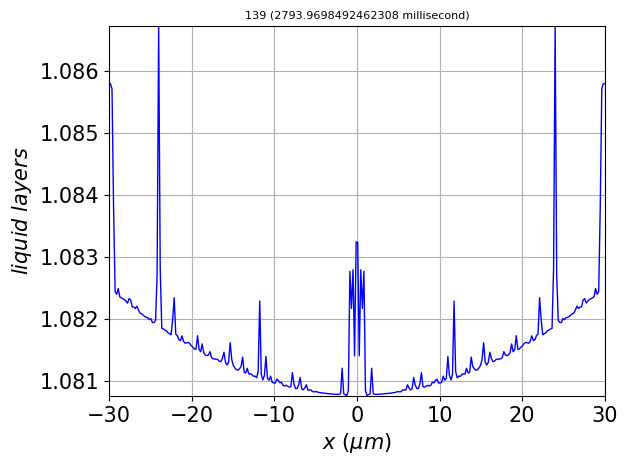

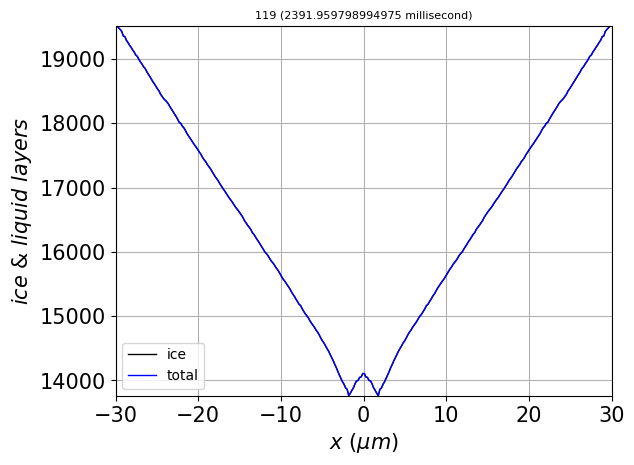

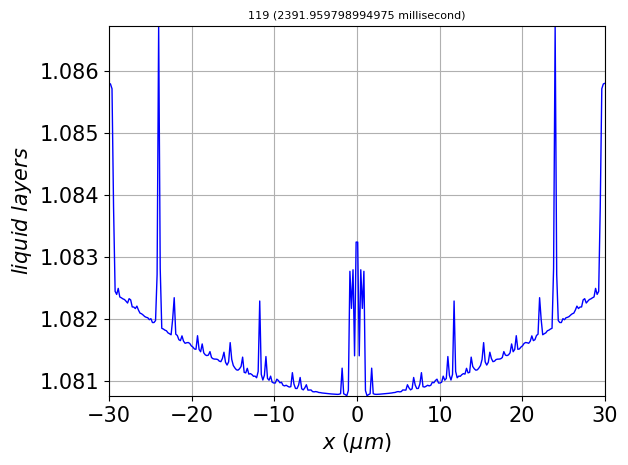

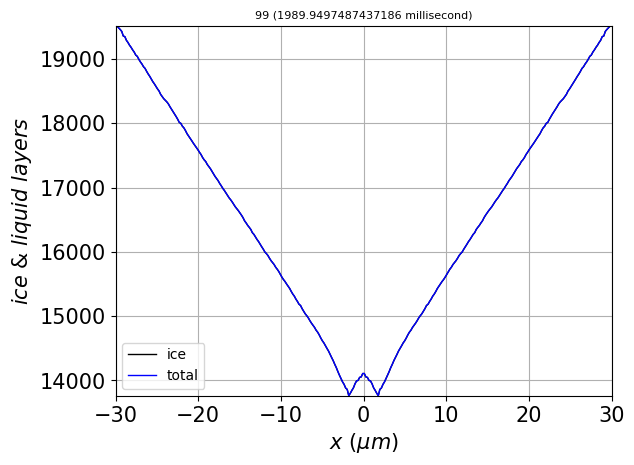

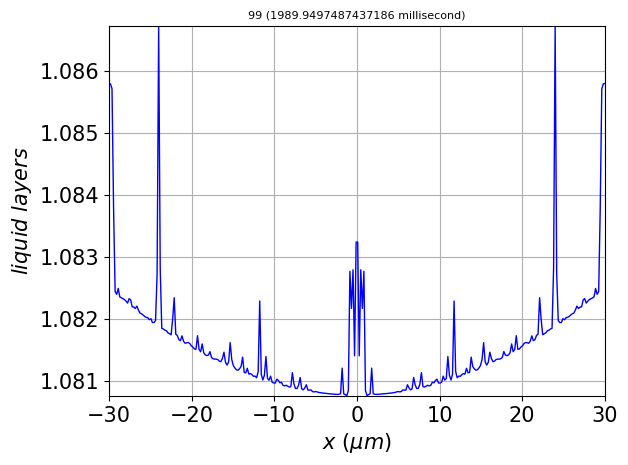

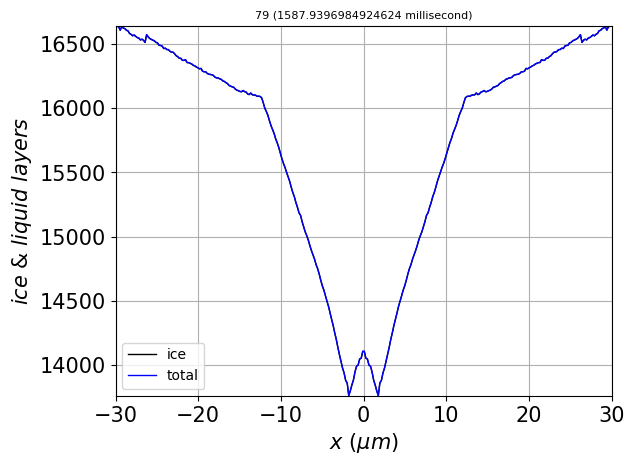

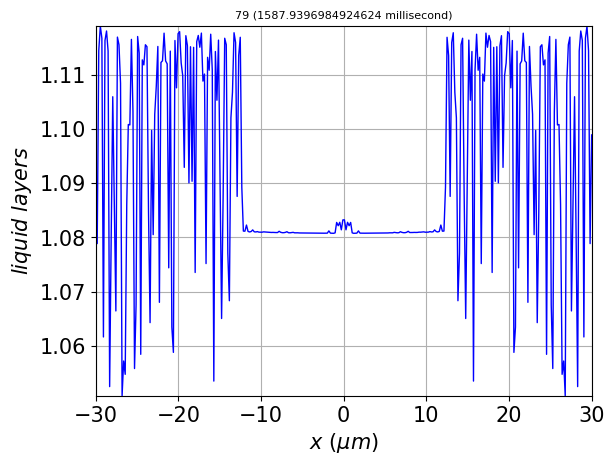

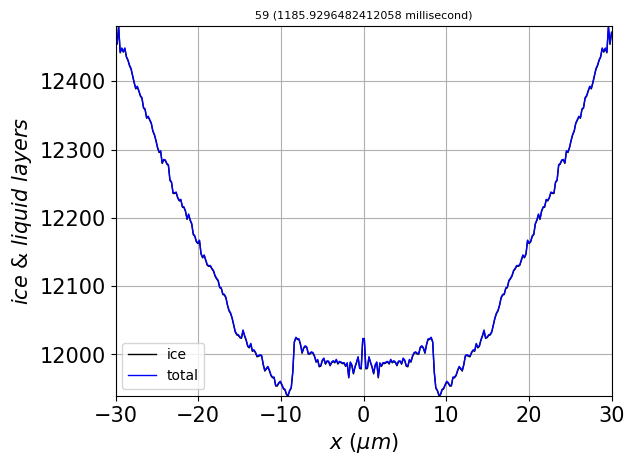

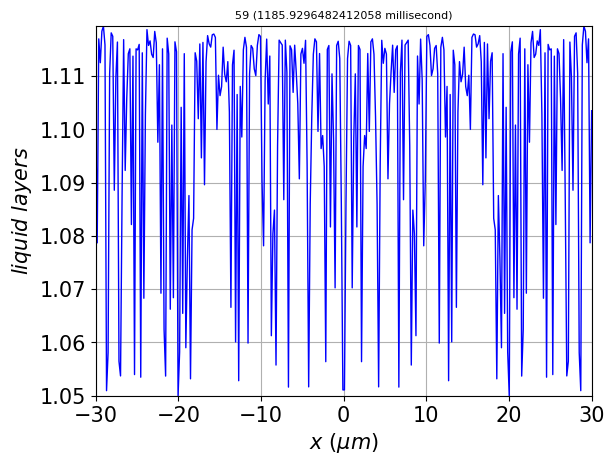

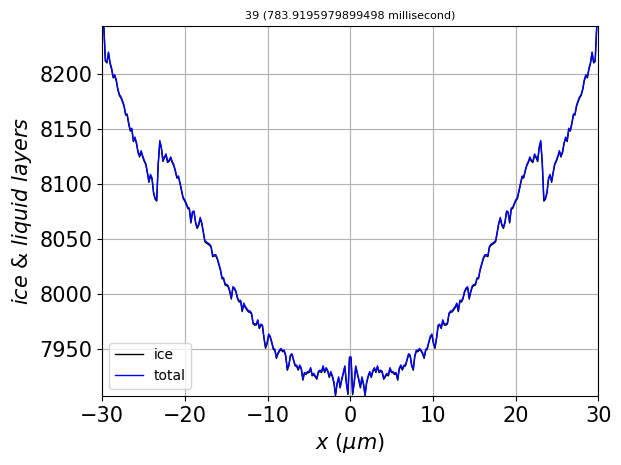

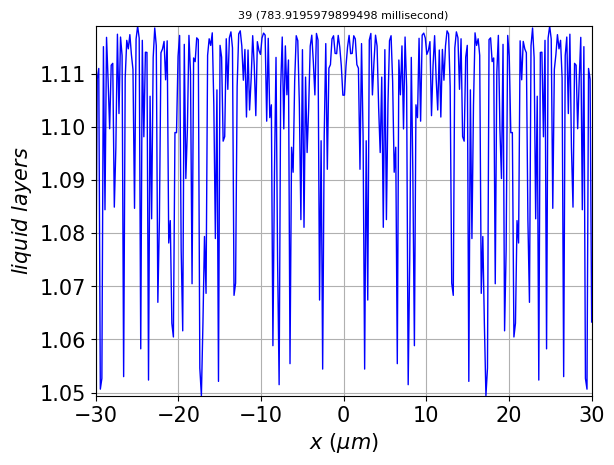

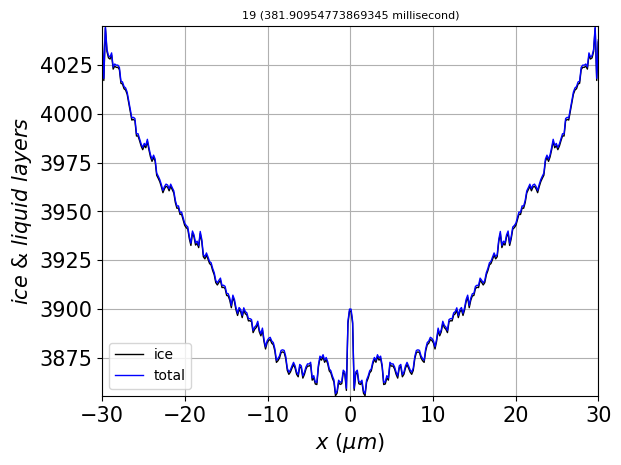

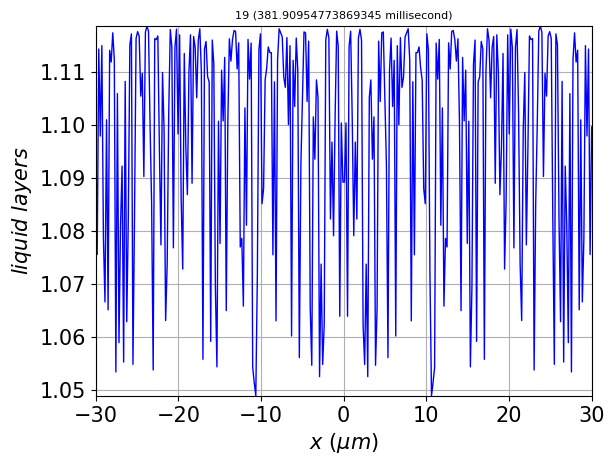

In [20]:
# Check out intermediate values
for itime in range(ntimes-1,0,-20):
    title_params = str(itime)+' ('+str(tkeep_1Darr[itime].to('millisecond'))+')'
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,tgraphics=False,title_params=title_params,itime=itime, \
        xlim=[-30,30])

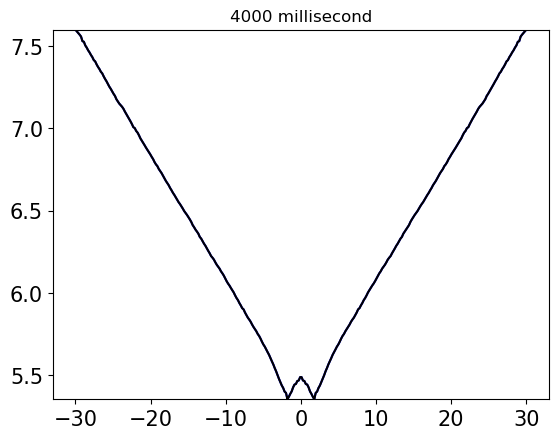

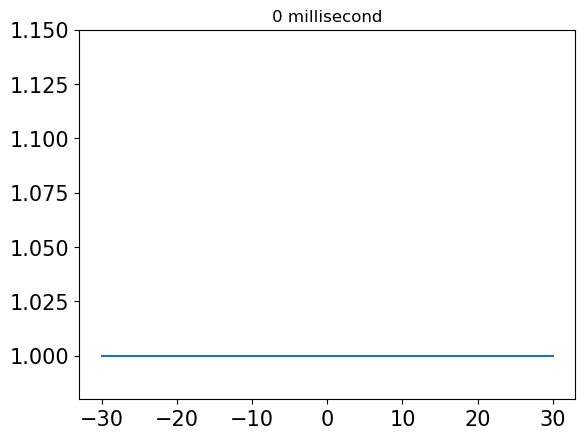

In [21]:
# # Animating Ntot and NQLL
# import matplotlib.animation as animation
x = x_QLC.magnitude

# # Ntot
# fig, ax = plt.subplots()
# yrange = np.max(Ntotkeep_1D[-1,:])-np.min(Nicekeep_1D[-1,:])
# def animate(i):
#     ax.clear()
#     plt.plot(x,Ntotkeep_1D[i,:],'blue')
#     plt.plot(x,Nicekeep_1D[i,:],'black')
#     y1 = np.min([Nicekeep_1D[i,:]])
#     y2 = y1 + yrange   
#     plt.ylim([y1,y2])
#     seconds = tkeep_1Darr[i].to('msec')
#     seconds_str = f"{seconds.magnitude:0.000f}"
#     title_str = seconds_str + ' ' + str(seconds.units)
#     plt.title(str(title_str))
# ani = animation.FuncAnimation(fig, animate, interval=50, frames = ntimes, repeat = False)
# ani.save('Ntot.mp4')

# Ntot as height
fig, ax = plt.subplots()
Ntotkeep_1D_microns = Ntotkeep_1D*h_pr.magnitude
Nicekeep_1D_microns = Nicekeep_1D*h_pr.magnitude
yrange = np.max(Ntotkeep_1D_microns[-1,:])-np.min(Nicekeep_1D_microns[-1,:])
def animate(i):
    ax.clear()
    plt.plot(x,Ntotkeep_1D_microns[i,:],'blue')
    plt.plot(x,Ntotkeep_1D_microns[i,:],'black')
    y1 = np.min([Nicekeep_1D_microns[i,:]])
    y2 = y1 + yrange   
    plt.ylim([y1,y2])
    seconds = tkeep_1Darr[i].to('msec')
    seconds_str = f"{seconds.magnitude:0.000f}"
    title_str = seconds_str + ' ' + str(seconds.units)
    plt.title(str(title_str))
ani = animation.FuncAnimation(fig, animate, interval=50, frames = ntimes, repeat = False)
ani.save('Ntot_microns.mp4')

# NQLL
fig, ax = plt.subplots()
y1 = .98
y2 = 1.15
def animate(i):
    y = NQLLkeep_1D[i,:]
    ax.clear()
    plt.plot(x,y)
    plt.ylim([y1,y2])
    seconds = tkeep_1Darr[i].to('msec')
    seconds_str = f"{seconds.magnitude:0.000f}"
    title_str = seconds_str + ' ' + str(seconds.units)
    plt.title(str(title_str))
ani = animation.FuncAnimation(fig, animate, interval=50, frames = ntimes, repeat = False)
ani.save('NQLL.mp4')

Probing itime = -1
Probing time = 4000.0 millisecond
Shape of the smooth list is  (0,)
Parameters for partition among the three facets
beta_trans = 0.04366094290851206 dimensionless
delta_beta 0.004366094290851206 dimensionless
0.09000000000000001


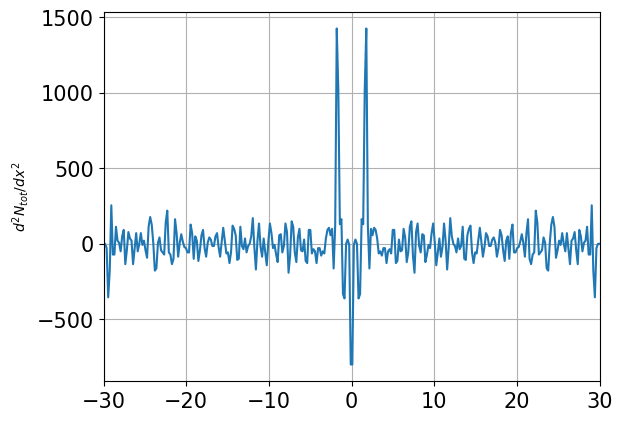

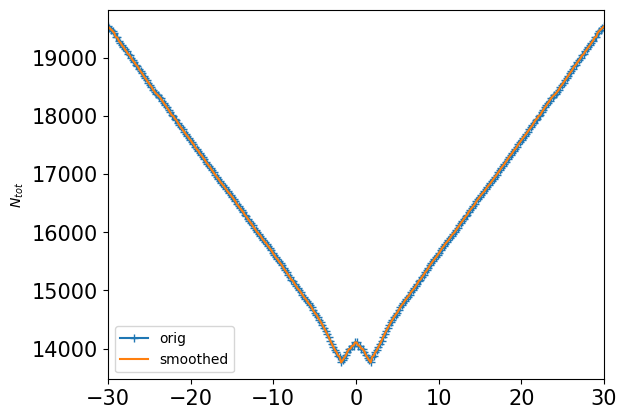

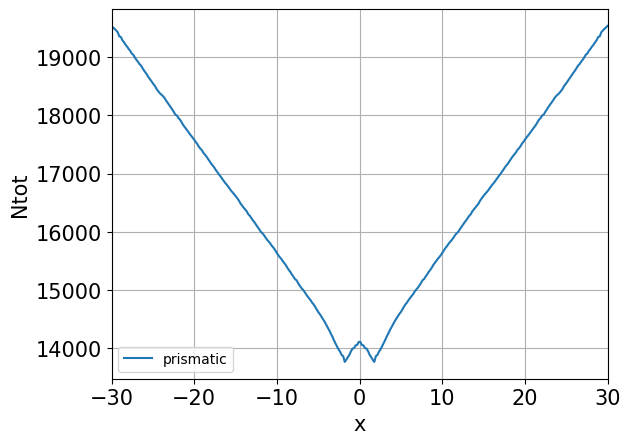

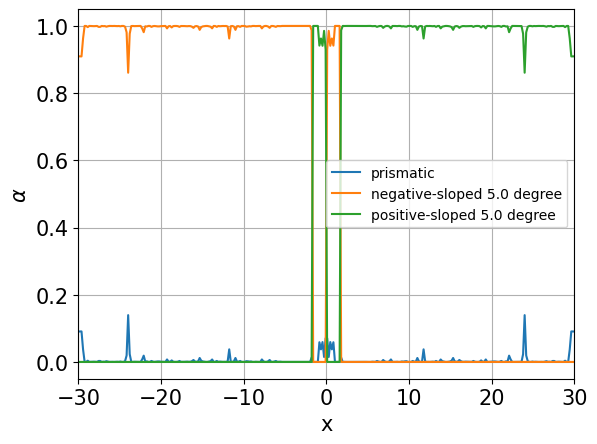

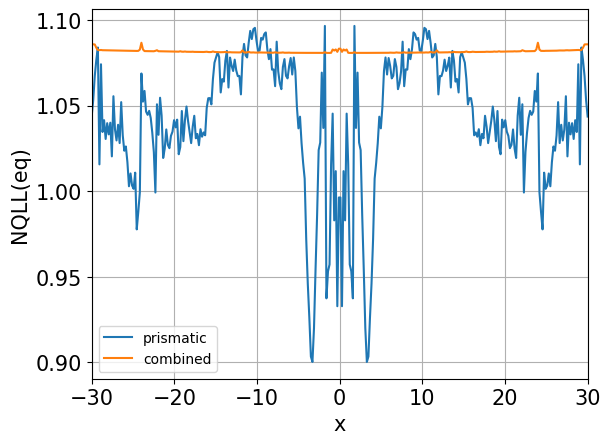

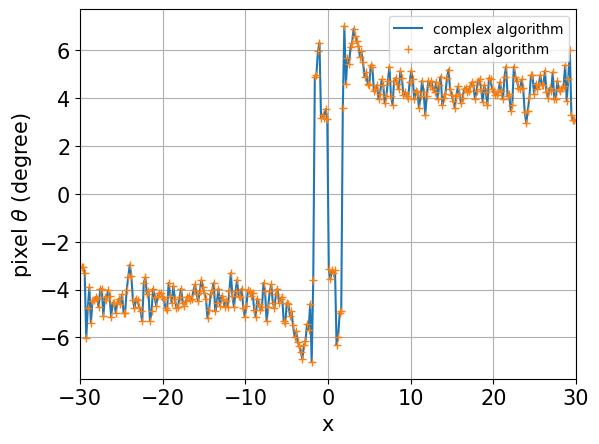

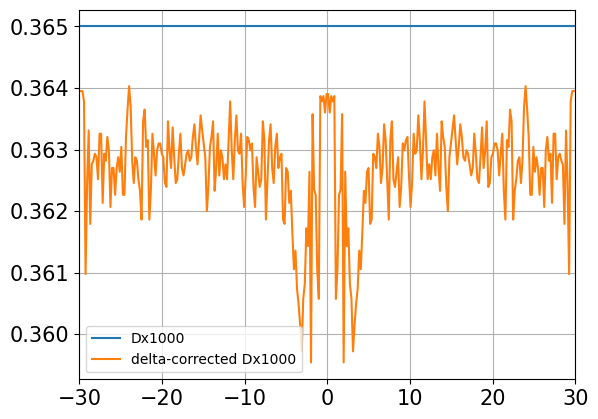

In [22]:
# Probing properties of multiple facet types
if microfacets == 1:
    itime = -1
    print('Probing itime =',itime)
    print('Probing time =',tkeep_1Darr[itime].to('millisecond'))
    Ntot_pr = Ntotkeep_1D[itime,:]
    NQLL_pr = NQLLkeep_1D[itime,:]
    xleft = -L.magnitude
    xright = L.magnitude
    
    # Checking out the smoothness algorithm
    d2Ntot_dx2, Ntot_pr_smoothed = QLC.smoothout(\
            x_QLC.magnitude,Ntot_pr,deltax.magnitude,d2Ntot_dx2_threshold.magnitude,verbose=2)                                      
    plt.figure()
    plt.plot(x_QLC.magnitude,d2Ntot_dx2)
    plt.grid(True)
    plt.ylabel(r'$d^2N_{tot}/dx^2$')
    plt.xlim([xleft,xright])
    plt.figure()
    plt.plot(x_QLC.magnitude,Ntot_pr,'-+',label='orig')
    plt.plot(x_QLC.magnitude,Ntot_pr_smoothed,label='smoothed')
    plt.ylabel(r'$N_{tot}$')
    plt.legend()
    plt.xlim([xleft,xright])
    
    # Specifying how to partition among the three facets
    print('Parameters for partition among the three facets')
    beta_trans = np.sin(theta/2)/np.cos(theta/2)
    print('beta_trans =', beta_trans)
    delta_beta = beta_trans/beta_trans_factor
    print('delta_beta',delta_beta)

    # Visualizing Ntot of the various faceting frames
    h_py = h_pr*h_pyfactor
    Ntot_pyneg = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr -np.sin(theta)*x_QLC)
    Ntot_pypos = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr +np.sin(theta)*x_QLC)
    plt.figure()
    plt.plot(x_QLC.magnitude,Ntot_pr,label='prismatic')
    # plt.plot(x_QLC.magnitude,Ntot_pyneg,label='negative-sloped '+str(theta))
    # plt.plot(x_QLC.magnitude,Ntot_pypos,label='positive-sloped '+str(theta))
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel('Ntot',fontsize=fontsize)
    plt.grid(True)
    plt.legend()
    plt.xlim([xleft,xright])

    # Checking out the algorithm for calculating microfacet weights
    z_pr = h_pr * Ntot_pr
    dx = x_QLC[1]-x_QLC[0]
    beta = np.gradient(z_pr,dx)
    beta.ito('dimensionless')
    alpha_pyneg = QLC.get_alpha(beta.magnitude,-beta_trans.magnitude,delta_beta.magnitude)
    alpha_pypos = 1-QLC.get_alpha(beta.magnitude, beta_trans.magnitude,delta_beta.magnitude)
    alpha_pr = 1 - alpha_pyneg - alpha_pypos
    plt.figure()
    plt.plot(x_QLC.magnitude,alpha_pr,label='prismatic')
    plt.plot(x_QLC.magnitude,alpha_pyneg,label='negative-sloped '+str(theta.to('degree')))
    plt.plot(x_QLC.magnitude,alpha_pypos,label='positive-sloped '+str(theta.to('degree')))
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel(r'$\alpha$',fontsize=fontsize)
    plt.legend()
    plt.grid(True)
    plt.xlim([xleft,xright])

    # Checking out the algorithm for calculating the weighted NQLL_eq
    Nstar_pr = Nstar
    Nstar_py = Nstar_pr*Nstarfactor; print(Nstar_py)
    NQLL_eq_pr    = Nbar - Nstar_pr*np.sin(2*np.pi*Ntot_pr)
    NQLL_eq_pyneg = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pyneg.magnitude)
    NQLL_eq_pypos = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pypos.magnitude)
    NQLL_eq = alpha_pr*NQLL_eq_pr + alpha_pyneg*NQLL_eq_pyneg + alpha_pypos*NQLL_eq_pypos
    plt.figure()
    plt.plot(x_QLC.magnitude,NQLL_eq_pr,label='prismatic')
    # plt.plot(x_QLC.magnitude,NQLL_eq_pyneg,label='negative-sloped '+str(theta))
    # plt.plot(x_QLC.magnitude,NQLL_eq_pypos,label='positive-sloped '+str(theta))
    plt.plot(x_QLC.magnitude,NQLL_eq,label='combined')
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel('NQLL(eq)',fontsize=fontsize)
    plt.legend()
    plt.grid(True)
    plt.xlim([xleft,xright])

    # Algorithm for calculating angles from slopes
    slopes = np.ones(len(x_QLC)) + 1j*beta.magnitude
    angles = AssignQuantity(np.angle(slopes),'radian')
    angles.ito('degree')
    angles_from_atan = np.arctan(beta.magnitude)*180/np.pi
    if np.max(np.abs(angles.magnitude)) < 0.1:
        common_factor = 1000
        extra_label = ' x '+str(common_factor)
    else:
        common_factor = 1
        extra_label = ''
    plt.figure()
    plt.plot(x_QLC.magnitude,angles.magnitude,label='complex algorithm'+extra_label)
    plt.plot(x_QLC.magnitude,angles_from_atan,'+',label='arctan algorithm'+extra_label)
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel(r'pixel $\theta$ ('+str(angles.units)+')',fontsize=fontsize)
    plt.grid(True)
    plt.xlim([xleft,xright])
    plt.legend()
    
    # The delta-corrected diffusion coefficient (multiplying by a common factor so it has units of um^2/us)
    factor_for_display = deltax**2*1000
    Doverdeltax2_array = Doverdeltax2.magnitude*np.ones(len(x_QLC))
    Doverdeltay2_array = Doverdeltax2.magnitude*np.cos(angles)**2 # Corrected
    Doverdeltay2_array = Doverdeltay2_array.magnitude
    plt.figure()
    plt.plot(x_QLC.magnitude,Doverdeltax2_array*factor_for_display.magnitude,label='Dx1000')
    plt.plot(x_QLC.magnitude,Doverdeltay2_array*factor_for_display.magnitude,label='delta-corrected Dx1000')
    plt.grid(True)
    plt.xlim([xleft,xright])
    plt.legend()